In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv("../CSV/CamposNovosPOWER.csv", delimiter=',')

In [3]:
df.head()

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
0,-27.38339,-51.21929,1984,1,8.63,1.14,19.58,83.16,26.95,18.77,22.58,43.56,20.20,22.60
1,-27.38339,-51.21929,1984,2,7.18,1.14,19.45,83.54,26.46,18.16,22.38,43.52,24.34,22.46
2,-27.38339,-51.21929,1984,3,12.46,1.25,19.27,91.43,23.27,18.32,20.71,43.52,12.31,20.57
3,-27.38339,-51.21929,1984,4,9.24,1.53,19.35,85.57,26.84,17.54,21.91,43.49,23.62,22.07
4,-27.38339,-51.21929,1984,5,2.06,1.86,20.11,86.48,27.28,18.38,22.49,43.45,20.92,22.65


In [4]:
Mai15OY = int(365/2 - 30)
if df.LAT[0]<0 :
    Mai15OY = 365-31-30-31
Mai15OY

273

In [5]:
df.drop(['LAT', 'LON'], axis=1)

,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
0,1984,1,8.63,1.14,19.58,83.16,26.95,18.77,22.58,43.56,20.20,22.60
1,1984,2,7.18,1.14,19.45,83.54,26.46,18.16,22.38,43.52,24.34,22.46
2,1984,3,12.46,1.25,19.27,91.43,23.27,18.32,20.71,43.52,12.31,20.57
3,1984,4,9.24,1.53,19.35,85.57,26.84,17.54,21.91,43.49,23.62,22.07
4,1984,5,2.06,1.86,20.11,86.48,27.28,18.38,22.49,43.45,20.92,22.65
...,...,...,...,...,...,...,...,...,...,...,...,...
13562,2021,48,0.20,1.23,15.03,79.42,24.32,14.21,18.62,-99.00,-99.00,18.88
13563,2021,49,0.12,1.22,13.66,77.12,23.68,11.89,17.67,-99.00,-99.00,17.72
13564,2021,50,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
13565,2021,51,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00


# FRANCE :
Pour atteindre sa maturité le soja doit cumuler en sec 1 400 °C jour (variété 000) à 1 440 °C jour (variété 00) auquel il faut rajouter une semaine pour obtenir la date de récolte. En 2017 la carte ci-dessous nous montre que pour des levées du 15 mai on peut espérer récolter sur septembre dans la plupart des secteurs.

Les levées plus tardives devront certainement patienter sur début octobre. Après la mi-octobre, avec la réduction de la durée du jour, l’humidité et la pluviométrie, il est difficile de descendre en dessous de 18-20 % d’humidité. La qualité des graines risque d’être rapidement altérée par le développement de moisissures (graines colorées en noir à la surface du grain). Si la récolte s’annonce tardive, il est donc conseillé de récolter, même si l’humidité atteint 20 à 25 %. Dans ce cas, livrer la récolte le plus rapidement possible car les graines ne se conservent pas à plus de 14 % d’humidité. A noter qu’il n’y a plus aucun produit autorisé pour défaner chimiquement le soja.

In [6]:
def get_AnneeCouvree(dataframe):
    return (dataframe.YEAR[len(dataframe)-1] - dataframe.YEAR[0]) 

In [7]:
def definir_periode_dataset(date_deb, dataframe, temp_point, incidence = 0):
    date_deb = date_deb - incidence                                         #Déterminer l'incidence à quelques jours
    
    ind = 0                                                                 #Indice TAB
    AnneeCouvree = get_AnneeCouvree(dataframe)                              #Nombre d'année couvrée 2021 - 1984?
    temp_sol = [0] * AnneeCouvree                                           #Initialisation Tableau
    
    i = 0
    while i < len(dataframe)-1:                                            #Parcours du data frame
        if(dataframe.DOY[i]>date_deb):                                     #Si le jour couvrant l'année en cours correspond à la première quinzaine de Mai
            temp_sol[ind] = temp_sol[ind] + dataframe.TS[i]                #On additionne la température

        if(temp_sol[ind]>=temp_point):                                     #Si la température arrive à un total de 1400 degrée 
            temp_sol[ind] = i+7 + incidence                                #On récupère l'indice de fin afin de préparer la découpe du df + une semaine
            while(dataframe.DOY[i]>date_deb):                              #On s'arrête ici, nous devons alors nous déplacer vers la nouvelle année
                i = i+1 
            if (ind+1) < AnneeCouvree:                                     #La dernière année sera bien traité, mais nous devons bloquer l'accès afin d'éviter quelconque débordement d'indice  
                ind = ind + 1  

        i = i+1
    return temp_sol

In [8]:
periode = definir_periode_dataset(Mai15OY, df, 1400)
df.DOY[Mai15OY:periode[0]]

273    274
274    275
275    276
276    277
277    278
      ... 
349    350
350    351
351    352
352    353
353    354
Name: DOY, Length: 81, dtype: int64

In [9]:
def decoupe_dataset(dataframe, periode):
    begin = dataframe.DOY==Mai15OY
    first_index = df[begin].index

    i = 0
    df_ = pd.DataFrame(index=dataframe.index, columns=dataframe.columns)
    df_ = df_.fillna(0)

    for end_index in periode:
        df_[first_index[i]:end_index]=dataframe[first_index[i]:end_index]
        i = i+1
    
    df_ = df_[(df_.T != 0).any()] #avoid 0 value on full line
    return df_

In [10]:
df_ = decoupe_dataset(df, periode)
df_

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
272,-27.38339,-51.21929,1984,273,0.08,1.48,8.70,80.09,18.23,7.62,12.01,34.45,17.64,12.50
273,-27.38339,-51.21929,1984,274,0.00,1.28,9.73,78.91,22.03,6.56,13.40,34.63,26.46,13.80
274,-27.38339,-51.21929,1984,275,0.00,1.47,10.60,76.79,23.18,9.05,14.69,34.85,27.00,15.02
275,-27.38339,-51.21929,1984,276,0.06,1.41,11.63,74.60,24.93,9.45,16.20,35.03,24.59,16.21
276,-27.38339,-51.21929,1984,277,0.23,1.35,13.89,77.69,27.19,9.24,18.06,35.24,20.41,17.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562,-27.38339,-51.21929,2021,48,0.20,1.23,15.03,79.42,24.32,14.21,18.62,-99.00,-99.00,18.88
13563,-27.38339,-51.21929,2021,49,0.12,1.22,13.66,77.12,23.68,11.89,17.67,-99.00,-99.00,17.72
13564,-27.38339,-51.21929,2021,50,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
13565,-27.38339,-51.21929,2021,51,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00


In [11]:
# La bibliothèque numpy offre plusieurs fonctions très utiles. Par exemple, elle nous permet de créer une nouvelle colonne dans notre
# dataframe si une condition est satisfaite

def imputeColumns(dataset):
    """ Pour chacune des colonnes du dataset,
        mise à jour des valeurs < par la moyenne de ses valeurs non nulles.
    """
    # liste des colonnes qui seront traitées
    columnsToImpute=['PRECTOT', 'WS2M', 'T2MDEW','RH2M', 'T2M_MAX', 'T2M_MIN' ,'T2M', 'ALLSKY_TOA_SW_DWN', 'ALLSKY_SFC_SW_DWN', 'TS']

    for c in columnsToImpute:
        avgOfCol=dataset[dataset[c]>=0][[c]].mean()
        dataset[c]=np.where(dataset[[c]]>=0,dataset[[c]],avgOfCol)

imputeColumns(df_)

# check that we've imputed the -99 values  
df_

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
272,-27.38339,-51.21929,1984,273,0.080000,1.480000,8.700000,80.090000,18.230000,7.620000,12.010000,34.450000,17.640000,12.500000
273,-27.38339,-51.21929,1984,274,0.000000,1.280000,9.730000,78.910000,22.030000,6.560000,13.400000,34.630000,26.460000,13.800000
274,-27.38339,-51.21929,1984,275,0.000000,1.470000,10.600000,76.790000,23.180000,9.050000,14.690000,34.850000,27.000000,15.020000
275,-27.38339,-51.21929,1984,276,0.060000,1.410000,11.630000,74.600000,24.930000,9.450000,16.200000,35.030000,24.590000,16.210000
276,-27.38339,-51.21929,1984,277,0.230000,1.350000,13.890000,77.690000,27.190000,9.240000,18.060000,35.240000,20.410000,17.920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562,-27.38339,-51.21929,2021,48,0.200000,1.230000,15.030000,79.420000,24.320000,14.210000,18.620000,40.347265,20.868626,18.880000
13563,-27.38339,-51.21929,2021,49,0.120000,1.220000,13.660000,77.120000,23.680000,11.890000,17.670000,40.347265,20.868626,17.720000
13564,-27.38339,-51.21929,2021,50,5.504246,1.408904,15.036197,78.873687,24.735973,13.477348,18.892135,40.347265,20.868626,19.078978
13565,-27.38339,-51.21929,2021,51,5.504246,1.408904,15.036197,78.873687,24.735973,13.477348,18.892135,40.347265,20.868626,19.078978


In [12]:
df_=df_.drop(columns=['LAT','LON', 'DOY'], axis =1 )

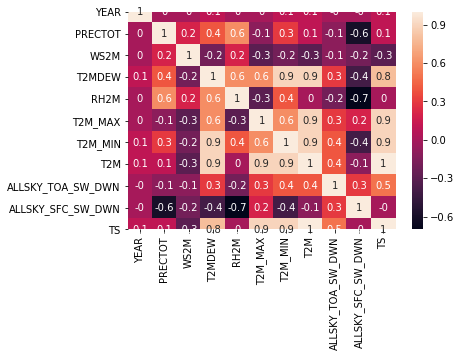

In [13]:
%matplotlib inline

matrice_corr = df_.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

In [14]:
#['T2M', 'ALLSKY_SFC_SW_DWN', 'T2MDEW', 'T2M_MIN', 'YEAR', 'RH2M', 'surface (ha)']

In [15]:
df_sojaSM = pd.read_csv("../CSV/soja_Campos_Novos_1974_2018.txt", sep="\t")
df_sojaSM.head()

,Annee,surface (ha),Production (t),Productivite (kg/ha),Productivite (sacs/ha)
0,1974,15000,19000,1200,20.0
1,1975,15000,18000,1200,20.0
2,1976,20000,24000,1200,20.0
3,1977,23000,34500,1500,25.0
4,1978,38000,36100,950,15.8


In [16]:
selection = df_sojaSM.Annee<1984
index2Remove = df_sojaSM[selection].index
df_sojaSM=df_sojaSM.drop(index2Remove)

In [17]:
X_VAL = df_[df_.YEAR==2019]

In [18]:
X_VAL.to_csv("2019Soja_CN.csv", index=False)

In [19]:
selection = df_.YEAR>2018
index2Remove = df_[selection].index
df_=df_.drop(index2Remove)

In [20]:
cmp = df_sojaSM.index[0]
for r in df_.index:
    if df_.YEAR[r] != df_sojaSM.Annee[cmp]:
        cmp = cmp+1
        
    if df_.YEAR[r] == df_sojaSM.Annee[cmp]:
        df_.at[r, 'Productivite (kg/ha)'] = df_sojaSM.at[cmp, 'Productivite (kg/ha)']
        df_.at[r, 'Production (t)'] = df_sojaSM.at[cmp, 'Production (t)']
        df_.at[r, 'surface (ha)'] = df_sojaSM.at[cmp, 'Production (t)']

In [21]:
df_.describe()

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha)
count,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000
mean,2000.996171,5.503575,1.410331,14.995374,79.254045,24.580975,13.372005,18.770463,40.327453,20.851788,18.944191,2385.092934,84485.975983,84485.975983
std,10.080991,9.392159,0.436043,3.135357,7.589221,2.816884,3.123273,2.693204,2.772022,8.365275,2.621301,800.640448,61006.902907,61006.902907
min,1984.000000,0.000000,0.450000,2.590000,48.330000,11.910000,1.810000,8.680000,34.000000,0.790000,9.530000,800.000000,16800.000000,16800.000000
25%,1992.000000,0.060000,1.090000,12.890000,74.350000,22.980000,11.270000,16.990000,38.120000,14.470000,17.200000,1800.000000,47880.000000,47880.000000
50%,2001.000000,1.110000,1.340000,15.410000,79.250000,24.770000,13.540000,19.040000,40.970000,22.860000,19.200000,2400.000000,56700.000000,56700.000000
75%,2010.000000,7.000000,1.660000,17.350000,84.630000,26.430000,15.740000,20.730000,42.880000,27.650000,20.800000,2700.000000,105600.000000,105600.000000
max,2018.000000,74.140000,3.540000,21.700000,95.950000,35.320000,21.130000,26.110000,44.800000,34.670000,26.800000,4200.000000,254100.000000,254100.000000


# Coefficient de Pearson

Le coefficient de Pearson ou Pearson r est une mesure qui exprime à quel point deux variables sont linéairement corrélées. Il est égale au quotient de la covariance des deux variables et du produit des deux écarts-types

In [22]:
from scipy.stats import pearsonr
for c in df_.columns:
    coeff_pearson,_ = pearsonr(df_[c],df_['Productivite (kg/ha)'])
    print(c, "coefficient de Pearson = {}".format(coeff_pearson))

YEAR coefficient de Pearson = 0.7598891835141044
PRECTOT coefficient de Pearson = 0.018143982729918212
WS2M coefficient de Pearson = -0.006062998986857395
T2MDEW coefficient de Pearson = 0.09366554338169168
RH2M coefficient de Pearson = 0.1525814032453792
T2M_MAX coefficient de Pearson = -0.03826453654028889
T2M_MIN coefficient de Pearson = 0.06075101769176826
T2M coefficient de Pearson = 0.019824459250152145
ALLSKY_TOA_SW_DWN coefficient de Pearson = -0.01405186236023072
ALLSKY_SFC_SW_DWN coefficient de Pearson = -0.020751690995750183
TS coefficient de Pearson = 0.01367792949982906
Productivite (kg/ha) coefficient de Pearson = 1.0
Production (t) coefficient de Pearson = 0.8833190665677982
surface (ha) coefficient de Pearson = 0.8833190665677982


Nous pouvons observer une forte corrélation 

In [23]:
coeff_pearson,_ = pearsonr(df_sojaSM.Annee,df_sojaSM['Productivite (kg/ha)'])
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = 0.759754424592635


In [24]:
 #PAS GÉNÉRIQUE !   
cmp = df_sojaSM.index[0]
firstYear = True
for r in df_.index:
    if firstYear :
        df_.at[r, 'Coeff_prod'] = 0 ##Année ref

    if df_.YEAR[r] != df_sojaSM.Annee[cmp]:
        cmp = cmp+1
        firstYear = False
    
    if df_.YEAR[r] == df_sojaSM.Annee[cmp] and firstYear == False:
        coef_prod = (df_sojaSM.at[cmp, 'Productivite (kg/ha)']/df_sojaSM.at[cmp-1, 'Productivite (kg/ha)'])
        df_.at[r, 'Coeff_prod'] = coef_prod


df_.describe()

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha),Coeff_prod
count,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000
mean,2000.996171,5.503575,1.410331,14.995374,79.254045,24.580975,13.372005,18.770463,40.327453,20.851788,18.944191,2385.092934,84485.975983,84485.975983,1.047322
std,10.080991,9.392159,0.436043,3.135357,7.589221,2.816884,3.123273,2.693204,2.772022,8.365275,2.621301,800.640448,61006.902907,61006.902907,0.404325
min,1984.000000,0.000000,0.450000,2.590000,48.330000,11.910000,1.810000,8.680000,34.000000,0.790000,9.530000,800.000000,16800.000000,16800.000000,0.000000
25%,1992.000000,0.060000,1.090000,12.890000,74.350000,22.980000,11.270000,16.990000,38.120000,14.470000,17.200000,1800.000000,47880.000000,47880.000000,0.875000
50%,2001.000000,1.110000,1.340000,15.410000,79.250000,24.770000,13.540000,19.040000,40.970000,22.860000,19.200000,2400.000000,56700.000000,56700.000000,1.016393
75%,2010.000000,7.000000,1.660000,17.350000,84.630000,26.430000,15.740000,20.730000,42.880000,27.650000,20.800000,2700.000000,105600.000000,105600.000000,1.185185
max,2018.000000,74.140000,3.540000,21.700000,95.950000,35.320000,21.130000,26.110000,44.800000,34.670000,26.800000,4200.000000,254100.000000,254100.000000,2.531250


In [25]:
coeff_pearson,_ = pearsonr(df_.Coeff_prod,df_['Productivite (kg/ha)'])
print("coefficient de Pearson = {}".format(coeff_pearson))
#Les points tombent près de la ligne, ce qui indique une relation négative forte entre les variables. La relation est négative car lorsqu'une variable chute, l'autre variable chute aussi.

coefficient de Pearson = 0.2821928164577326


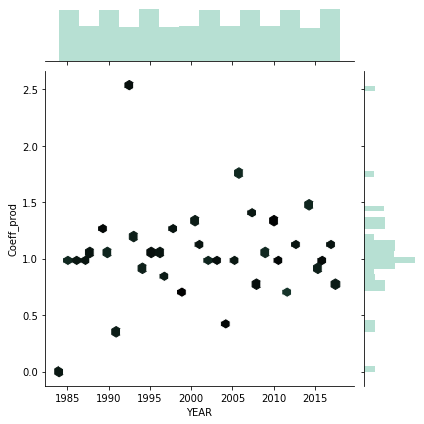

In [26]:
x = df_.YEAR
y = df_['Coeff_prod']

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

Nous pouvons observer très clairement cette courbe que nous souhaitons désormais applatir 

In [27]:
columnsNamesArr = ['YEAR']
df_features = df_[columnsNamesArr]
# définir la variable cible
df_labels = df_[['Coeff_prod']]

X_scaled = df_features
Y_scaled = df_[['Coeff_prod']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=1)
3
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=None, n_estimators=100)
clf.fit(X_train, y_train.values.ravel())

RandomForestRegressor()

In [28]:
moylast5Y = 0
cmp = 0
for r in df_.index:
    if df_.YEAR[r] > (df_.YEAR.max() - 10):
        cmp=cmp+1
        moylast5Y = moylast5Y + df_.Coeff_prod[r]

In [29]:
moylast5Y = moylast5Y / cmp
moylast5Y

1.0566433490342544

In [30]:
estimated_2019 = clf.predict([[2019]])
coeff_prod_2019 = estimated_2019 * moylast5Y

In [31]:
coeff_prod_2019

array([0.83021977])

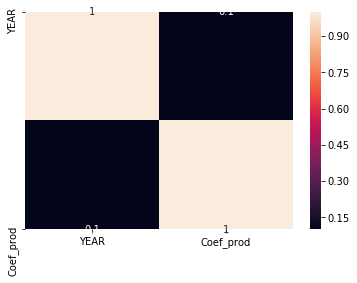

In [32]:
year_inflation = pd.DataFrame(df_.YEAR)
year_inflation["Coef_prod"]=df_.Coeff_prod
#year_inflation["Productivite (kg/ha)"]=df_["Productivite (kg/ha)"]
matrice_corr = year_inflation.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

# Année ref

In [33]:
class AnneeRef:        
    def __init__(self, Annee, Dataframe):
        self.Annee = Annee
        self.df_ = pd.DataFrame()
        self.df_ = self.df_.append(Dataframe[Dataframe.YEAR==(Annee-1)], ignore_index=True)
        self.df_.loc[self.df_.YEAR==(Annee-1), "YEAR"]=Annee
        self.DOY = 0
    
    def put_back_year(self):
        self.df_.YEAR=self.Annee
        
    def addRow(self, row):
        for columns in row:
            self.df_.loc[self.DOY, columns] = row[columns].values
        self.DOY = self.DOY + 1
        
    def slight_mean(self, Annee, Dataframe):
        size_df = len(self.df_)
        size_param = len(Dataframe[Dataframe.YEAR==Annee])
        if(size_df<size_param):
            for i in range(0, size_df):
                df1 = pd.DataFrame()
                df1 = df1.append(Dataframe[Dataframe.YEAR==Annee], ignore_index=True)
                self.df_.loc[i]=self.df_.loc[i].add(df1.loc[i], fill_value=0)
                self.df_.loc[i] = self.df_.loc[i].div(2)
        else:
            for i in range(0, size_param):
                df1 = pd.DataFrame()
                df1 = df1.append(Dataframe[Dataframe.YEAR==Annee], ignore_index=True)
                self.df_.loc[i]=self.df_.loc[i].add(df1.loc[i], fill_value=0)
                self.df_.loc[i] = self.df_.loc[i].div(2)
    
        self.put_back_year()
       
    def historical_average(self, Dataframe):
        startPoint = df_.YEAR[df_.YEAR.index[0]]
        endPoint = df_.YEAR[df_.YEAR.idxmax()]
        selection = df_.YEAR==startPoint
        for i in range(startPoint, endPoint):
            Year = int(df_[selection].iloc[0].YEAR)
            self.slight_mean(Year, self.df_)

In [34]:
annee_ = AnneeRef(2019, df_)
annee_.Annee = 2021
annee_.put_back_year()
#row_1 = pd.DataFrame(df_[df_.YEAR==2001].head(1))
#annee_.addRow(row_1)
#annee_.slight_mean(2018, df_)
#annee_.slight_mean(2017, df_)
#annee_.slight_mean(2016, df_)
annee_.historical_average(df_)
annee_.df_

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha),Coeff_prod
0,2021,4.97,1.10,17.26,82.13,25.55,16.57,20.38,34.52,9.89,20.56,3300.0,207900.0,207900.0,0.785714
1,2021,1.61,1.41,17.42,84.38,25.83,14.78,20.12,34.71,15.71,20.35,3300.0,207900.0,207900.0,0.785714
2,2021,33.56,1.25,18.45,93.91,23.60,15.58,19.48,34.90,12.61,19.36,3300.0,207900.0,207900.0,0.785714
3,2021,10.21,1.40,16.44,89.91,22.75,14.91,18.13,35.09,9.27,18.39,3300.0,207900.0,207900.0,0.785714
4,2021,0.23,1.17,11.55,74.05,22.58,11.20,16.11,35.27,22.99,16.63,3300.0,207900.0,207900.0,0.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2021,16.20,1.29,19.31,74.13,30.00,19.50,24.11,43.42,13.00,24.29,3300.0,207900.0,207900.0,0.785714
77,2021,8.90,1.09,20.39,80.89,28.57,19.79,23.82,43.44,28.01,23.78,3300.0,207900.0,207900.0,0.785714
78,2021,3.41,1.10,20.66,81.72,29.02,19.82,23.94,43.46,27.27,23.75,3300.0,207900.0,207900.0,0.785714
79,2021,11.81,1.24,20.44,82.71,27.93,18.88,23.51,43.48,15.52,23.41,3300.0,207900.0,207900.0,0.785714


In [35]:
#A faire
# -> Par rapport à une moyenne historique

In [36]:
# Nous pourrions alors faire un update sur les données journalière et ajouter les lignes au fur et à mesure que le dataset évolue

In [37]:
#Utiliser les données producteur (échelle de ville à producteur)

# REGRESSION

In [38]:
columnsNamesArr = ['PRECTOT', 'T2M', 'ALLSKY_SFC_SW_DWN', 'T2MDEW', 'T2M_MIN', 'RH2M', 'YEAR', 'Coeff_prod']
df_features = df_[columnsNamesArr]
# définir la variable cible
df_labels = df_[['Productivite (kg/ha)']]

# SCALE DATA

Le Feature Scaling est une étape nécessaire voire indispensable de remise à niveau de caractéristiques de notre modèle de Machine Learning. Pourquoi ? et bien tout simplement car derrière chaque algorithme se cache des formules mathématiques. Et ces formules mathématiques n’apprécient guère les variations d’échelle de valeurs entre chaque caractéristiques.

In [39]:
X_scaled = df_features
Y_scaled = df_labels

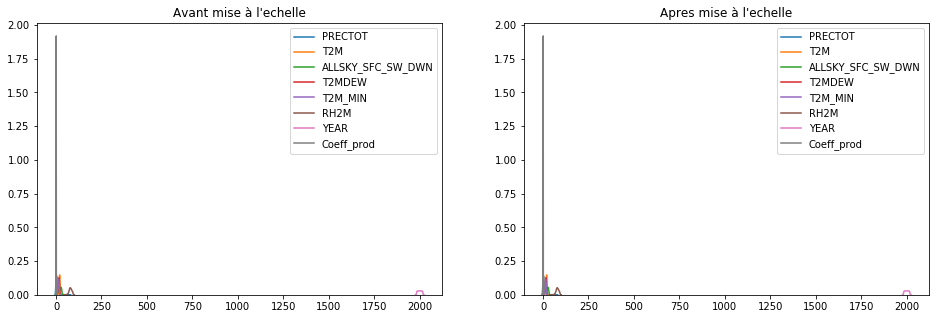

In [40]:
def plotGraph(pdf, pscaled_df):
    fig, (a, b) = plt.subplots(ncols=2, figsize=(16, 5))
    a.set_title("Avant mise à l'echelle")
    for col in pdf.columns:
        sns.kdeplot(pdf[col], ax=a)
    b.set_title("Apres mise à l'echelle")
    for col in pscaled_df.columns:
        sns.kdeplot(pscaled_df[col], ax=b)
    plt.show()

plotGraph(df_features, X_scaled)
#plotGraph(df_[['Productivite (kg/ha)']], Y_scaled)

# TRAIN

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2298, 8)
(575, 8)
(2298, 1)
(575, 1)


In [42]:
rf = RandomForestRegressor(max_depth=14, n_estimators=157, random_state=1)
rf.fit(X_train, y_train.values.ravel())

train_score = rf.score(X_train, y_train)
print('train score = ',train_score )

ypred = rf.predict(X_test)
mse = mean_squared_error(ypred  , y_test)
rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
print(' Random Forest RMSE = ',rmse_rf_test )

r2_rf = r2_score(y_test, ypred)
print(' Random Forest R2 = ',r2_rf)

ypred = rf.predict(X_train)
mse = mean_squared_error(ypred  , y_train)
rmse_rf_train = np.sqrt(mean_squared_error(ypred,y_train))
print(' Random Forest TRAIN RMSE = ',rmse_rf_train )

#faire un affichage du déroulement

train score =  1.0
 Random Forest RMSE =  0.0
 Random Forest R2 =  1.0
 Random Forest TRAIN RMSE =  0.0


In [43]:
print('Random Forest Cross-validation scores')
sc_rfc = cross_val_score(rf, X_test, y_test.values.ravel(), cv=5)
print("AUC: %0.2f (+/- %0.2f)" % (sc_rfc.mean(), sc_rfc.std() * 2))

Random Forest Cross-validation scores
AUC: 1.00 (+/- 0.00)


In [44]:
#Kfold validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)


for train_index, test_index in kf.split(X_scaled):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("----------------------------------------------")
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = Y_scaled.iloc[train_index], Y_scaled.iloc[test_index]
    rf = RandomForestRegressor(max_depth=14, n_estimators=50, random_state=1)
    rf.fit(X_train, y_train.values.ravel())

    train_score = rf.score(X_train, y_train)
    print('train score = ',train_score )

    ypred = rf.predict(X_test)
    mse = mean_squared_error(ypred  , y_test)
    rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
    print(' Random Forest RMSE = ',rmse_rf_test )

    r2_rf = r2_score(y_test, ypred)
    print(' Random Forest R2 = ',r2_rf)

----------------------------------------------
train score =  1.0
 Random Forest RMSE =  432.60515741519106
 Random Forest R2 =  -58.17734822468785
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  364.8620934301373
 Random Forest R2 =  -0.6327482131636801
----------------------------------------------
train score =  0.9999924853245145
 Random Forest RMSE =  100.0887245286789
 Random Forest R2 =  0.9749484826135917
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  160.96845406965588
 Random Forest R2 =  0.23154046373715076
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  282.43782779090935
 Random Forest R2 =  0.3053707708021681
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  1130.4311409634513
 Random Forest R2 =  -1.8036078149346753
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  905.067

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2298, 8)
(575, 8)
(2298, 1)
(575, 1)


In [46]:
rf = RandomForestRegressor(max_depth=14, n_estimators=50, random_state=1)
rf.fit(X_train, y_train.values.ravel())

train_score = rf.score(X_train, y_train)
print('train score = ',train_score )

ypred = rf.predict(X_test)
mse = mean_squared_error(ypred  , y_test)
rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
print(' Random Forest RMSE = ',rmse_rf_test )

r2_rf = r2_score(y_test, ypred)
print(' Random Forest R2 = ',r2_rf)

ypred = rf.predict(X_train)
mse = mean_squared_error(ypred  , y_train)
rmse_rf_train = np.sqrt(mean_squared_error(ypred,y_train))
print(' Random Forest TRAIN RMSE = ',rmse_rf_train )

train score =  1.0
 Random Forest RMSE =  0.0
 Random Forest R2 =  1.0
 Random Forest TRAIN RMSE =  0.0


In [47]:
append = open("results.txt","a")
append.write("\n\n------------NOVOS CAMPOS-------------\n")

40

In [48]:
append = open("results.txt","a")
cmp = X_VAL.index[0]
size = len(X_VAL)
for i in range(cmp, cmp+size):
    X_VAL.at[i, "Coeff_prod"]=4080/3300
    
X_VAL_Features = X_VAL[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 4080 - ypred[0])

str1 = "Novos-Campos production [réel coeff production]: {} - Errreur:~ {}\n".format(ypred[0], 4080-ypred[0])
append.write(str1)

cmp = X_VAL.index[0]
size = len(X_VAL)
for i in range(cmp, cmp+size):
    X_VAL.at[i, "Coeff_prod"]=moylast5Y
    
X_VAL_Features = X_VAL[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 4080 - ypred[0])

str1 = "Novos-Campos production [moyenne des dernières année]: {} - Errreur:~ {}\n".format(ypred[0], 4080-ypred[0])
append.write(str1)

cmp = X_VAL.index[0]
size = len(X_VAL)
for i in range(cmp, cmp+size):
    X_VAL.at[i, "Coeff_prod"]=coeff_prod_2019
    
X_VAL_Features = X_VAL[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 4080 - ypred[0])

str1 = "Novos-Campos production [coeff determiné pour 2019]: {} - Errreur:~ {}\n".format(ypred[0], 4080-ypred[0])
append.write(str1)

4164.0
Erreur:~ -84.0
3452.4
Erreur:~ 627.5999999999999
3300.0
Erreur:~ 780.0


78

In [50]:
df_moy = annee_.df_
cmp = df_moy.index[0]
size = len(df_moy)
for i in range(cmp, cmp+size):
    df_moy.at[i, "Coeff_prod"]=4080/3200
    
X_VAL_Features = df_moy[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 4080 - ypred[0])

append = open("results.txt","a")
str1 = "\nSantaMaria production [vrai coeff production + Moyenne historique]: {} - Erreur:~ {} \n".format(ypred[0], 4080 - ypred[0])
append.write(str1)
append.close()

4164.0
Erreur:~ -84.0
